# Ставки и M2

In [1]:
import pandas as pd
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.api import durbin_watson, acorr_breusch_godfrey # DW & LM-тесты
from statsmodels.iolib.summary2 import summary_col # вывод подгонки

# настройки визуализация
import pandas_datareader.data as web

import matplotlib.pyplot as plt

# Не показывать Warning
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Данные
Из БД [FRED](https://fred.stlouisfed.org/) загрузим месячные данные

* M2 (M2SL)
* 3-Month Treasury Bill Secondary Market Rate (TB3MS)
* Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity (GS10)
* Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity (GS1)
* Moody's Seasoned Aaa Corporate Bond Yield (AAA)
* Moody's Seasoned Baa Corporate Bond Yield (BAA)

c 2000-01 по 2023-12

In [2]:
start_date = '2000-01-01'
end_date = '2023-12-31'
data = web.DataReader(['TB3MS', 'GS1', 'GS10', 'AAA', 'BAA', 'M2SL'], 'fred', start=start_date, end=end_date)
data

,TB3MS,GS1,GS10,AAA,BAA,M2SL
DATE,,,,,,
2000-01-01,5.32,6.12,6.66,7.78,8.33,4666.2
2000-02-01,5.55,6.22,6.52,7.68,8.29,4679.4
2000-03-01,5.69,6.22,6.26,7.68,8.37,4710.2
2000-04-01,5.66,6.15,5.99,7.64,8.40,4766.1
2000-05-01,5.79,6.33,6.44,7.99,8.90,4753.9
...,...,...,...,...,...,...
2023-08-01,5.30,5.37,4.17,4.95,6.02,20765.4
2023-09-01,5.32,5.44,4.38,5.13,6.16,20711.0
2023-10-01,5.34,5.42,4.80,5.61,6.63,20691.7


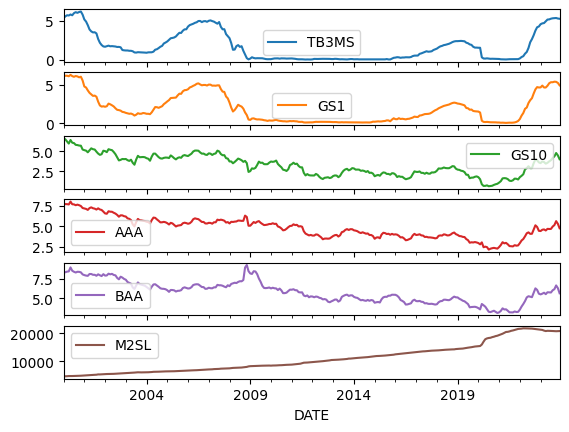

In [3]:
# график исходных данных
data.plot(subplots=True)
plt.show()

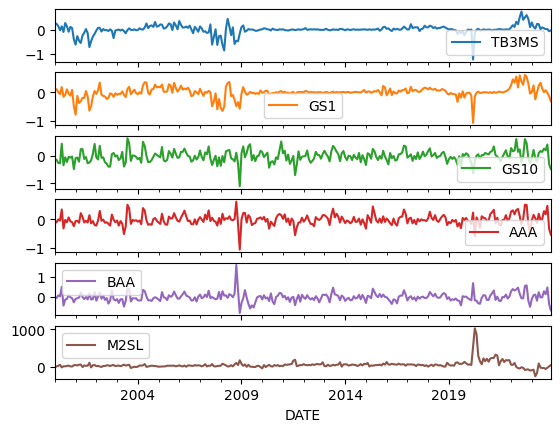

In [4]:
# график дифференцированных данных
data.diff().plot(subplots=True)
plt.show()

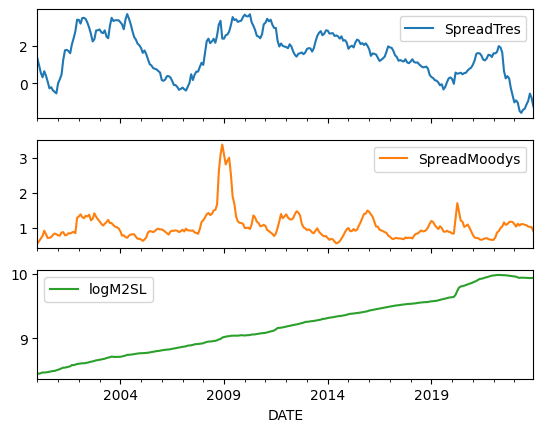

In [5]:
spreads = pd.DataFrame({'SpreadTres': data['GS10']-data['TB3MS'], 
                        'SpreadMoodys': data['BAA']-data['AAA'], 
                        'logM2SL': np.log(data['M2SL']) })
spreads.plot(subplots=True)

plt.show()

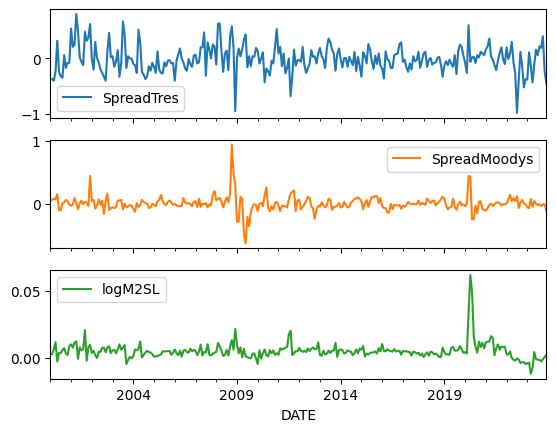

In [6]:
spreads.diff().plot(subplots=True)
plt.show()

## Модель

In [7]:
spreads.diff()

,SpreadTres,SpreadMoodys,logM2SL
DATE,,,
2000-01-01,NaN,NaN,NaN
2000-02-01,-0.37,0.06,0.002825
2000-03-01,-0.40,0.08,0.006560
2000-04-01,-0.24,0.07,0.011798
2000-05-01,0.32,0.15,-0.002563
...,...,...,...
2023-08-01,0.22,-0.01,-0.001338
2023-09-01,0.19,-0.04,-0.002623
2023-10-01,0.40,-0.01,-0.000932


In [8]:
df = spreads.diff().dropna()

In [9]:
mod = ols(formula='SpreadMoodys~SpreadTres+logM2SL', data=df)

res = mod.fit()

### Диагностика

In [10]:
# LM-тест на автокорреляцию 3-го порядка
lm, lmpval, fval, fpval = acorr_breusch_godfrey(res, nlags=3)
lm, lmpval

(59.7285438287963, 6.717988903751797e-13)

In [11]:
# DW-статистика
durbin_watson(res.resid)

1.1339950168657786

### Подгонка

In [12]:
mod = ols(formula='SpreadMoodys~SpreadTres+logM2SL', data=df)

res_ols = mod.fit()
res_hac = mod.fit(cov_type='HAC', cov_kwds={'maxlags': None, 'use_correction':True})

summary_col(results=[res_ols, res_hac], stars=True)

,SpreadMoodys I,SpreadMoodys II
Intercept,-0.0190**,-0.0190
,(0.0092),(0.0116)
SpreadTres,-0.0049,-0.0049
,(0.0294),(0.0478)
logM2SL,3.8709***,3.8709**
,(1.1406),(1.6641)
R-squared,0.0392,0.0392
R-squared Adj.,0.0324,0.0324


In [13]:
# Значимость регрессии, P-значения
res_ols.f_pvalue, res_hac.f_pvalue

(0.0034409757840407388, 0.061826952537010205)